In [1]:
import os, sys
import io
import requests
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage as ski
import cv2
import torch
import piq

# local library of functions to connect to image server
import libutils.use_server as server

# Notebook to explore ideas for image metrics

In [2]:
img_path = server.init() 

server : http://imgserver.10.68.0.250.nip.io/data/andra


In [3]:
files = server.get_list(img_path)
print("nombre de fichiers disponibles", len(files))
dirnames = []
for i in range(len(files)):
    dirnames.append(files[i].split('/')[4])
    
listdir = set(dirnames)
realdir = []
photo_not_in_dir = []
for ldir in listdir:
    if '.jpg' in ldir:
        photo_not_in_dir.append(ldir)
    else:
        realdir.append(ldir)

Status Code 200
nombre de fichiers disponibles 2268


In [4]:
files[0]

'/data/andra/calci_photos/REP2104/Photos/GTR2004-12_0017_REP2104_0065_0161.jpg'

In [10]:
sortedlist = sorted(realdir)

### The variance of the Laplacian can be a measure of the sharpness of the image, or the focus

In [5]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

### Function to read a directory and return some metrics

Bundle the metric calculation into one function. Add some Facebook metrics too: `piq` PyTorch Image Quality
* https://github.com/photosynthesis-team/piq/blob/master/examples/image_metrics.py

In [6]:
def read_directory(dirname, allfiles, quiet=True):
    """
    Function to read all images in a directory and return a data frame with image metrics
    
    parameters
    ----------
    dirname
        Name of directory to be read
    allfiles
        List of all files in the image server
        
    returns
    -------
    df
        Pandas dataframe of image metrics
    
    """
    ImageId = []
    Path = []
    FileName = []
    DrillName = []
    Cote0 = []
    Cote1 = []
    PxSize = []
    PySize = []
    Focus = []
    BRISQUE_i = []
    BRISQUE_l = []

    for file in allfiles:
        if dirname in file:
            img = server.get_file(file, quiet)
            l0 = file.split('/')[-1]
            l1 = l0.split('.')[0]
            l2 = l1.split('_')
            if len(l2)<3:
                continue
            width, height = img.size
            ImageId.append(0)
            Path.append(file)
            FileName.append(l0)
            DrillName.append(l2[-3])
            Cote0.append(l2[-2])
            Cote1.append(l2[-1])
            PxSize.append(width)
            PySize.append(height)

            # focus metric
            gray = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
            Focus.append(variance_of_laplacian(gray))
            
            # pytorch image quality
            x = torch.tensor(np.asarray(img)).permute(2, 0, 1)[None, ...] / 255.
            if torch.cuda.is_available():
                # Move to GPU to make computaions faster
                x = x.cuda()
            brisque_index: torch.Tensor = piq.brisque(x, data_range=1., reduction='none')
            brisque_loss: torch.Tensor = piq.BRISQUELoss(data_range=1., reduction='none')(x)
            
            BRISQUE_i.append(brisque_index.item())
            BRISQUE_l.append(brisque_loss.item())


    d = {'ImageId':ImageId, 'Path':Path, 'FileName':FileName, 'DrillName':DrillName,
         'Cote0':Cote0, 'Cote1':Cote1, 'PxSize':PxSize, 'PySize':PySize, 'Focus':Focus,
         'BRISQUE index':BRISQUE_i, 'BRISQUE loss':BRISQUE_l}
    df = pd.DataFrame(data=d)
    
    return df

In [12]:
df = read_directory(sortedlist[1], files)
df.sort_values('Cote0')

,ImageId,Path,FileName,DrillName,Cote0,Cote1,PxSize,PySize,Focus,BRISQUE index,BRISQUE loss
5,0,/data/andra/calci_photos/BPE4024/Photos/GTR201...,GTR2012-07_0023_BPE4024_0000_0100.jpg,BPE4024,0000,0100,3091,654,300.416002,8.790710,8.790710
0,0,/data/andra/calci_photos/BPE4024/Photos/GTR201...,GTR2012-07_0023_BPE4024_0082_0190.jpg,BPE4024,0082,0190,3456,623,213.227945,15.649597,15.649597
7,0,/data/andra/calci_photos/BPE4024/Photos/GTR201...,GTR2012-07_0023_BPE4024_0180_0290.jpg,BPE4024,0180,0290,3456,630,175.342923,4.541199,4.541199
2,0,/data/andra/calci_photos/BPE4024/Photos/GTR201...,GTR2012-07_0023_BPE4024_0270_0380.jpg,BPE4024,0270,0380,3456,621,173.896013,8.957214,8.957214
1,0,/data/andra/calci_photos/BPE4024/Photos/GTR201...,GTR2012-07_0023_BPE4024_0350_0445.jpg,BPE4024,0350,0445,2945,640,155.098280,10.646179,10.646179
4,0,/data/andra/calci_photos/BPE4024/Photos/GTR201...,GTR2012-07_0023_BPE4024_0445_0530.jpg,BPE4024,0445,0530,2967,627,121.067875,9.771667,9.771667
6,0,/data/andra/calci_photos/BPE4024/Photos/GTR201...,GTR2012-07_0023_BPE4024_0510_0620.jpg,BPE4024,0510,0620,3456,630,190.445750,8.895203,8.895203
3,0,/data/andra/calci_photos/BPE4024/Photos/GTR201...,GTR2012-07_0023_BPE4024_0600_0665.jpg,BPE4024,0600,0665,2192,633,305.987149,5.283875,5.283875


Status Code 200


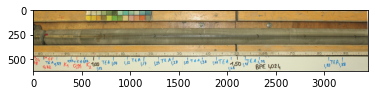

In [17]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmax()])
plt.imshow(img)
plt.show()

Status Code 200


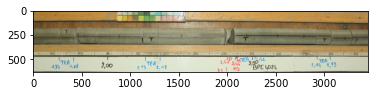

In [19]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmin()])
plt.imshow(img)
plt.show()